In [18]:
import numpy as np
import numba as nb
from scipy import integrate
from matplotlib import pyplot as plt

from numbalsoda import solve_ivp, lsoda_sig

# Simple Example

In [19]:
@nb.cfunc(lsoda_sig)
def f(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]
    
@nb.njit()
def f_scipy(t, u):
    return np.array([u[0]-u[0]*u[1],u[0]*u[1]-u[1]])

funcptr = f.address
u0 = np.array([5.,0.8])
data = np.array([1.0])
t_eval = np.linspace(0.0,50.0,1000)
t_span = np.array([min(t_eval),max(t_eval)])

In [20]:
sol = solve_ivp(funcptr, t_span, u0, t_eval = t_eval)

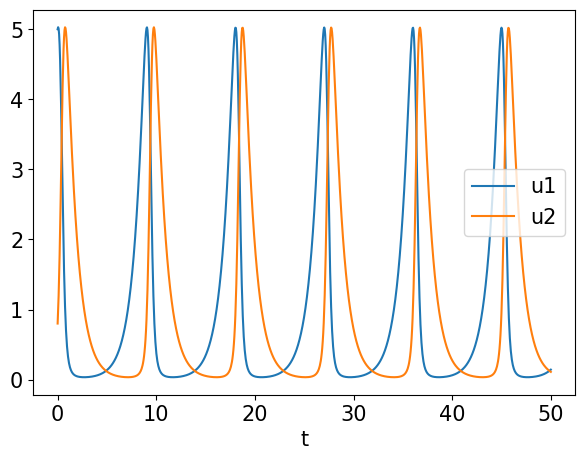

In [21]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(sol.t, sol.y[:,0],label='u1')
ax.plot(sol.t, sol.y[:,1],label='u2')
ax.legend()
ax.set_xlabel('t')

plt.show()

# Validation

In [22]:
# integrate backwards
t_eval = np.linspace(0.0,-50.0,1000)
t_span = np.array([max(t_eval),min(t_eval)])

sol = solve_ivp(funcptr, t_span, u0, t_eval = t_eval, rtol = 1e-9, atol = 1e-30)
sol_sp = integrate.solve_ivp(f_scipy, t_span, u0, t_eval = t_eval, rtol = 1e-9, atol = 1e-30)

print(np.all(np.isclose(sol_sp.y.T,sol.y)))

# integrate forwards
t_eval = np.linspace(0.0,50.0,1000)
t_span = np.array([min(t_eval),max(t_eval)])

sol = solve_ivp(funcptr, t_span, u0, t_eval = t_eval, rtol = 1e-9, atol = 1e-30)
sol_sp = integrate.solve_ivp(f_scipy, t_span, u0, t_eval = t_eval, rtol = 1e-9, atol = 1e-30)

print(np.all(np.isclose(sol_sp.y.T,sol.y)))

True
True


# Benchmark

In [23]:
t_nb = %timeit -o sol = solve_ivp(funcptr, t_span, u0, t_eval = t_eval, rtol = 1e-6, atol = 1e-30)

t_sp_LSODA = %timeit -o sol_sp = integrate.solve_ivp(f_scipy, t_span, u0, t_eval = t_eval,rtol = 1e-6, atol = 1e-30, method='LSODA')

t_sp_DOP = %timeit -o sol_sp = integrate.solve_ivp(f_scipy, t_span, u0, t_eval = t_eval,rtol = 1e-6, atol = 1e-30, method='DOP853')


123 µs ± 3.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
19.8 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.9 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
print("\nscipy solve_ivp took "+'%i'%(t_sp_LSODA.average/t_nb.average)+" times longer than numbalsoda solve_ivp")


scipy solve_ivp took 160 times longer than numbalsoda solve_ivp


# Simple event finding example

In [25]:
# we will search for one event
n_events = 1

@nb.cfunc(lsoda_sig)
def event(t, u, out, p):
    # Since we are searching for 1 event,
    # then `out` is an array of length 1.
    
    # Here we search for the point where u[0] == 1
    out[0] = u[0] - 1
    
event_fcn = event.address

sol = solve_ivp(funcptr, t_span, u0, t_eval = t_eval, n_events = n_events, event_fcn = event_fcn, rtol=1e-6)

print(sol.message)
print(sol.event_found)
print(sol.ind_event)
print(sol.t_event)
print(sol.y_event)

A termination event occurred.
True
0
0.7611343988149699
[1.         5.02890877]


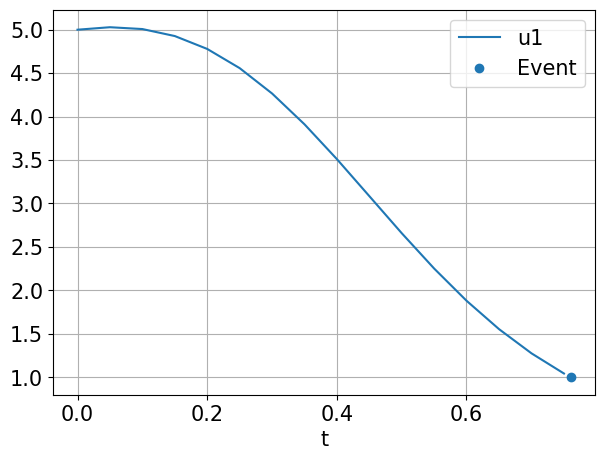

In [26]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(sol.t, sol.y[:,0],label='u1')
ax.plot(sol.t_event, sol.y_event[0],'C0o',label='Event')

ax.legend()
ax.set_xlabel('t')
ax.grid()

plt.show()

In [27]:
# Here we do the same thing with scipy
@nb.njit
def event_sp(t, u):
    return u[0] - 1

event_sp.terminal = True

sol_sp = integrate.solve_ivp(f_scipy, t_span, u0, t_eval = t_eval, events=event_sp, rtol=1e-6)

print(sol_sp.message)
print(sol_sp.t_events[0][0])
print(sol_sp.y_events[0][0])


A termination event occurred.
0.7611340147250184
[1.         5.02890745]


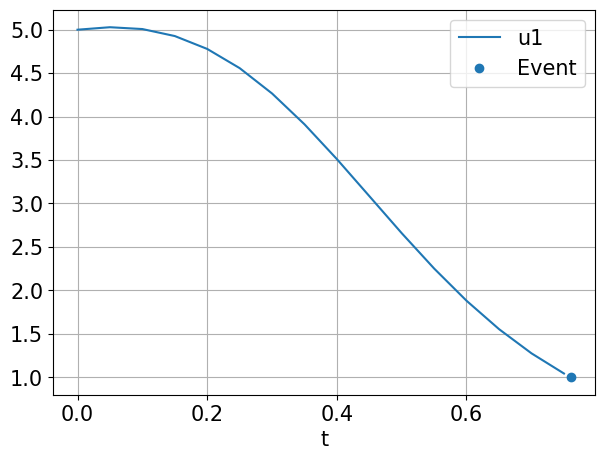

In [28]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(sol_sp.t, sol_sp.y[0,:],label='u1')
ax.plot(sol_sp.t_events[0][0], sol_sp.y_events[0][0][0],'C0o',label='Event')

ax.legend()
ax.set_xlabel('t')
ax.grid()

plt.show()

In [29]:
# We do a benchmark with event finding
%timeit sol = solve_ivp(funcptr, t_span, u0, t_eval = t_eval, n_events = n_events, event_fcn = event_fcn, rtol=1e-6)
%timeit sol_sp = integrate.solve_ivp(f_scipy, t_span, u0, t_eval = t_eval, events=event_sp, rtol=1e-6)

103 µs ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.46 ms ± 5.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Complicated event finding (passing data)

In [37]:
from numbalsoda import address_as_void_pointer
from numba import types

In [46]:
def rhs(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]*np.sum(p.arr1)
    du[1] = u[0]*u[1]-u[1]*np.sum(p.arr2)
    
# def events(t, u, out, p):
#     out[0] = u[0] - 1

In [52]:
# use numba.types.Record.make_c_struct to build a 
# a c structure.

# 'arr1_p' is the memory address of array arr1
# 'arr1_len' is the length of array arr1
args_dtype = types.Record.make_c_struct([
    ('arr1_p', types.uintp),
    ('arr1_len', types.int64),
    ('arr2_p', types.uintp),
    ('arr2_len', types.int64),
])

# This will be a class for our user data
spec = [
    ('arr1', types.double[:]),
    ('arr2', types.double[:]),
]

@nb.experimental.jitclass(spec)
class UserData():
    
    def __init__(self):    
        pass
        
    def make_args_dtype(self):
        args = np.zeros(1,dtype=args_dtype)
        args[0][0] = self.arr1.ctypes.data
        args[0][1] = self.arr1.shape[0]
        args[0][2] = self.arr2.ctypes.data
        args[0][3] = self.arr2.shape[0]
        return args
    
    def unpack_pointer(self, user_data_p):
        # takes in pointer, and unpacks it
        user_data = nb.carray(user_data_p, 1)[0]
        self.arr1 = nb.carray(address_as_void_pointer(user_data.arr1_p),(user_data.arr1_len), dtype=np.float64)
        self.arr2 = nb.carray(address_as_void_pointer(user_data.arr2_p),(user_data.arr2_len), dtype=np.float64)

In [53]:
# this function will create the numba function to pass to lsoda.
# def create_jit_fcns(rhs, events, args_dtype):
def create_jit_fcns(rhs, args_dtype):
    jitted_rhs = nb.njit(rhs)
    @nb.cfunc(types.void(types.double,
             types.CPointer(types.double),
             types.CPointer(types.double),
             types.CPointer(args_dtype)))
    def wrapped_rhs(t, u, du, user_data_p):    
        p = UserData()
        p.unpack_pointer(user_data_p)
        jitted_rhs(t, u, du, p) 
    
    # jitted_events = nb.njit(events)
    # @nb.cfunc(types.void(types.double,
    #          types.CPointer(types.double),
    #          types.CPointer(types.double),
    #          types.CPointer(args_dtype)))
    # def wrapped_events(t, u, du, user_data_p):
    #     p = UserData()
    #     p.unpack_pointer(user_data_p)
    #     jitted_events(t, u, du, p) 
    return wrapped_rhs   #, wrapped_events

In [54]:
# create the function to be called
# rhs_cfunc, events_cfunc = create_jit_fcns(rhs, events, args_dtype)
rhs_cfunc = create_jit_fcns(rhs, args_dtype)

TypeError: cannot unpack non-iterable CFunc object

In [ ]:
p = UserData()
p.arr1 = np.ascontiguousarray(.1*np.ones(6, dtype=np.float64))
p.arr2 = np.ascontiguousarray(.05*np.ones(3, dtype=np.float64))
args = p.make_args_dtype()

In [ ]:
p.arr1 

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
funcptr = rhs_cfunc.address
n_events = 1
event_fcn = events_cfunc.address
u0 = np.array([5.,0.8])
t_eval = np.linspace(0.0,50.0,1000) 
t_span = np.array([min(t_eval),max(t_eval)])

# sol = solve_ivp(funcptr, t_span, u0, t_eval=t_eval, \
#     n_events=n_events, event_fcn=event_fcn, data=args.ctypes.data, rtol=1e-6)

sol = solve_ivp(funcptr, t_span, u0, t_eval=t_eval, \
    data=args.ctypes.data, rtol=1e-6)


print(sol.t_event)

0.7258968839312555


In [ ]:
# now we will do many integrations changing the data
@nb.njit()
def test(print_stuff):
    
    p = UserData()
    p.arr1 = np.ascontiguousarray(.1*np.ones(6, dtype=np.float64))
    p.arr2 = np.ascontiguousarray(.05*np.ones(3, dtype=np.float64))
    args = p.make_args_dtype()
    
    for i in range(10):
        # all we do is change arr1 and arr2
        p.arr1[:] = 0.1 - i*0.01
        p.arr2[:] = 0.1 + i*0.01
        
        # It is key that we do not delete these arrays, or remake them.
        # args_ptr contains the memory addresses of arr1 and arr2. 
        # So we only need to change the data in the arrays
        
        sol = solve_ivp(funcptr, t_span, u0, t_eval=t_eval, \
        n_events=n_events, event_fcn=event_fcn, data=args.ctypes.data, rtol=1e-6)
        
        # The events time will change because the arr1 and arr2 are changing
        if print_stuff:
            print(sol.t_event)
            
test(True)

0.7463063968797183
0.7679450731640902
0.7909998733859709
0.8157222725496439
0.8424776519856828
0.8718277396448795
0.9047034490300901
0.9428490823677691
0.9901493996386634
1.0587894770207842
